# Set-up

In [2]:
import os
import datetime
import glob
from cyvcf2 import VCF, Writer

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from utils import eid_to_repeats, get_draw_mapping, eid_to_patient_cohort, parse_date, ALL_CHRS, read_agg_snv, join_clinical
from utils import aggregate_snv_global_f3_path, aggregate_snv_chrom_f3_path, aggregate_snv_Mbps_f3_path, sbs_artifacts, derive_final_metrics
from aggregate_funcotator_utils import *
from utils import *

%matplotlib inline
sns.set(font_scale=1)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

ModuleNotFoundError: No module named 'utils'

## Data & Figures Directories

In [ ]:
base_path = '/data/scratch/xchen'
data_path = '/home/xchen@okta-oci.eitm.org/projects/STATE_analyses/data/'

input_data_dirs = ["fig" + str(num) for num in range(1, 8)]
_ = [os.makedirs('input_data/' + path, exist_ok=True) for path in input_data_dirs]
_ = [os.makedirs('plots/' + path, exist_ok=True) for path in input_data_dirs]

# Fig 1B: Signature recovery of contrived samples

In [ ]:
contrived_path = base_path + '/STATE_vcfs_f3_region_filtered/full_genome/'

contrived100 = contrived_path + 'EIBS-002GA_19226_1_20240607_vs_HG002_11434_10_20240607.ann.filtered3.vcf'
contrived1 = [
    contrived_path + 'EIBS-002GB_19227_1_20240607_vs_HG002_11434_10_20240607.ann.filtered3.vcf', 
    contrived_path + 'EIBS-002GB_19227_2_20240701_vs_HG002_11434_13_20240701.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GB_19227_3_20240716_vs_HG002_11434_14_20240716_0.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GB_19227_4_20240722_vs_HG002_11434_15_20240722_0.ann.filtered3.vcf',
]
contrived5 = [
    contrived_path + 'EIBS-002GC_19228_1_20240607_vs_HG002_11434_10_20240607.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GC_19228_2_20240701_vs_HG002_11434_13_20240701.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GC_19228_3_20240716_vs_HG002_11434_14_20240716.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GC_19228_4_20240722_vs_HG002_11434_15_20240722.ann.filtered3.vcf',
]
contrived10 = [
    contrived_path + 'EIBS-002GD_19229_1_20240607_vs_HG002_11434_10_20240607.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GD_19229_2_20240701_vs_HG002_11434_13_20240701_0.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GD_19229_3_20240722_vs_HG002_11434_15_20240722.ann.filtered3.vcf',
    contrived_path + 'EIBS-002GD_19229_4_20240716_vs_HG002_11434_14_20240716.ann.filtered3.vcf',
]

contrived_vcf_list = []
for path1,path5,path10 in zip(contrived1,contrived5,contrived10):
    vcf1 = read_vcf_to_pandas(path1, contig=None)
    vcf1['BT474_percent'] = 1
    contrived_vcf_list.append(vcf1)
    vcf5 = read_vcf_to_pandas(path5, contig=None)
    vcf5['BT474_percent'] = 5
    contrived_vcf_list.append(vcf5)
    vcf10 = read_vcf_to_pandas(path10, contig=None)
    vcf10['BT474_percent'] = 10
    contrived_vcf_list.append(vcf10)
    
contrived_vcf = pd.concat(contrived_vcf_list, axis=0)

In [ ]:
mmc3_path = data_path + 'mmc3.xlsx'
mmc3 = pd.read_excel(mmc3_path, sheet_name='WGS Clones&Stoks Signatures', header=1)
bt_mutsig = mmc3.loc[mmc3['Sample Name'] == 'BT-474']
bt_mutsig_mapping = bt_mutsig.to_dict(orient='index')
bt_mutsig_mapping = bt_mutsig_mapping[47]
bt_mutsig_mapping.pop('Sample Name')
bt_mutsig_mapping.pop('Cancer Type used in SigProfiler')
bt_mutsig_mapping.pop('Accuracy')
bt_mutsig_mapping.pop('ID')
sbs_cols = [col for col in bt_mutsig.columns if col.startswith('SBS')]
bt_mutsig_norm = bt_mutsig[sbs_cols].divide(bt_mutsig[sbs_cols].sum(axis=1), axis=0)
bt_mutsig_norm_mapping = bt_mutsig_norm.to_dict(orient='index')
bt_mutsig_norm_mapping = bt_mutsig_norm_mapping[47]

In [ ]:
agg_path = data_path + 'aggregate_snv_patient_global_f3.csv'
agg_global = derive_final_metrics_uncorrrected(pd.read_csv(agg_path))
agg_global['EIBS_short'] = agg_global['EIBS'].str.split('_', n=1, expand=True)[0]

In [ ]:
contrived_map = {
    'EIBS-002GA': 100,
    'EIBS-002GB': 1,
    'EIBS-002GC': 5,
    'EIBS-002GD': 10,
}
contrived = agg_global.loc[agg_global.EIBS_short.isin(contrived_map.keys())]
contrived['BT474_percent'] = [contrived_map[n] for n in contrived.EIBS_short]
contrived['replicate'] = contrived.EIBS.str.rsplit('_', n=2, expand=True)[1]

/tmp/ipykernel_864167/3602057711.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contrived['BT474_percent'] = [contrived_map[n] for n in contrived.EIBS_short]
/tmp/ipykernel_864167/3602057711.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contrived['replicate'] = contrived.EIBS.str.rsplit('_', n=2, expand=True)[1]


In [ ]:
contrived.index = contrived.EIBS_short
cosmic = contrived.filter(regex='^SBS.*_ratio$')
cosmic.columns = cosmic.columns.str.rstrip('_ratio')  # strip suffix at the right end only.
cosmic = cosmic[list(set(cosmic.columns) & set(bt_mutsig_mapping.keys()))]
cosmic['BT474_percent'] = [contrived_map[n] for n in cosmic.index]
cosmic_long = cosmic.melt(id_vars='BT474_percent', var_name='SBS', value_name='Activity_ratio')

In [ ]:
bt_mutsig_df = pd.DataFrame.from_dict(bt_mutsig_norm_mapping, orient='index', columns=['Activity_ratio']).reset_index()
bt_mutsig_df = bt_mutsig_df.rename(columns={'index': 'SBS'}) 
bt_mutsig_df = bt_mutsig_df.loc[bt_mutsig_df.SBS.isin(set(cosmic.columns) & set(bt_mutsig_mapping.keys()))]
bt_mutsig_df['BT474_percent'] = -1
cosmic_long = pd.concat([cosmic_long, bt_mutsig_df], axis=0)
cosmic_long = cosmic_long.sort_values('SBS')

## Save csv for plotting

In [ ]:
os.makedirs('input_data/fig1/recovery_figs', exist_ok=True)
os.makedirs('input_data/fig1/recovery_pct', exist_ok=True)
cosmic_long.to_csv('input_data/fig1/recovery_figs/sig_recovery.csv')

## Example plot

/home/xchen@okta-oci.eitm.org/jupyter_kernels/tensig/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xchen@okta-oci.eitm.org/jupyter_kernels/tensig/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xchen@okta-oci.eitm.org/jupyter_kernels/tensig/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


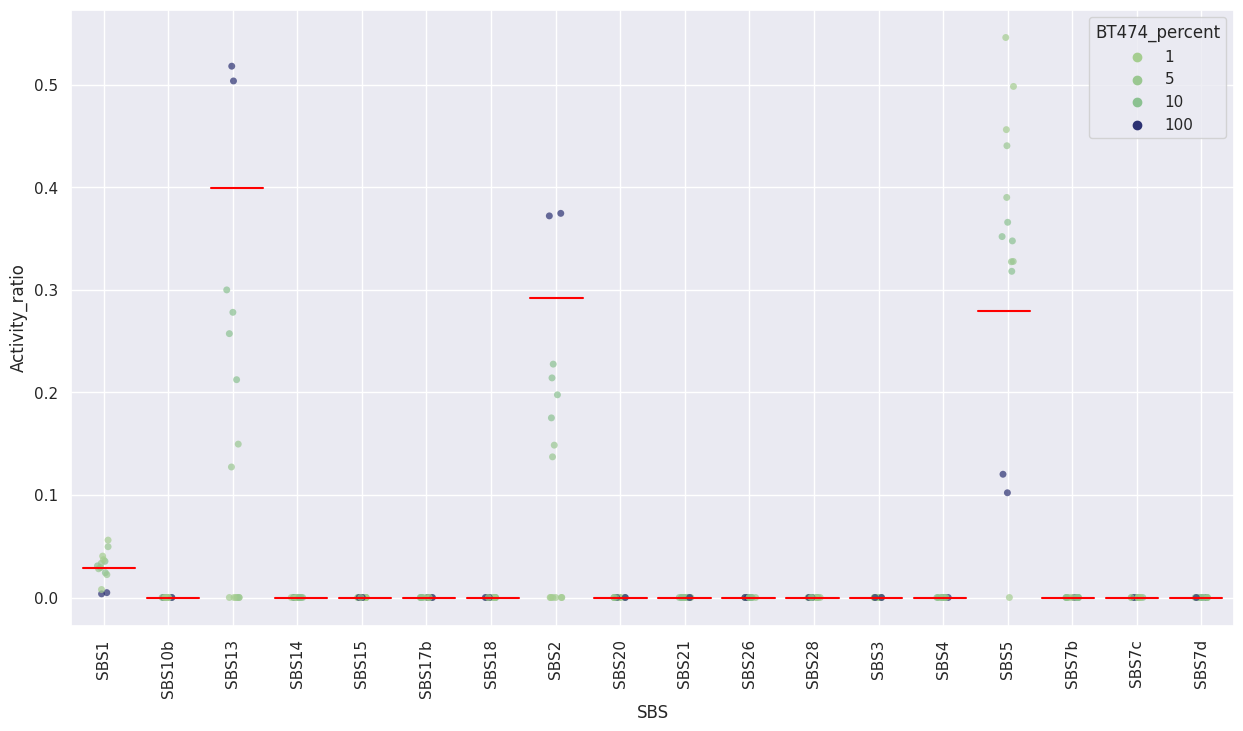

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(15,8))
# 
for i, row in enumerate(cosmic_long.loc[cosmic_long.BT474_percent == -1].iterrows()):
    _, SBS, activity = row[1]
    ax.axhline(y = activity,    # Line on y = 0.2
               xmin = 0.055*(i) + 0.01, # From the left
               xmax = 0.055*(i) + 0.055,
               color='red',
               zorder=10,
              )
sns.stripplot(cosmic_long.loc[cosmic_long.BT474_percent > -1], x='SBS', y='Activity_ratio', hue='BT474_percent', alpha=0.7, ax=ax, palette='crest')
ax.xaxis.grid(True) # Show the vertical gridlines
# ax.add_artist(seaborn_legend)
_ = plt.xticks(rotation=90)

# Fig 2: SNV Frequency Histogram Before Vs After Filtering

In [ ]:
def read_vcf_to_pandas(filepath, contig=None):
    vcf_dict = defaultdict(list)
    vcf = VCF(filepath)
    if contig is not None:
        vcf = vcf(contig)
    for v in vcf:
        update_vcf_dict(vcf_dict, v)
    return pd.DataFrame(vcf_dict)

failed_vcf_list = []
for input_vcf_path in glob.glob(os.path.join(base_path, 'STATE_vcfs_failed_f3_downsample', '*.vcf.gz')):
    vcf = read_vcf_to_pandas(input_vcf_path, contig=None)
    failed_vcf_list.append(vcf)
failed_vcf = pd.concat(failed_vcf_list, axis=0)

vcf_list = []
for input_vcf_path in glob.glob(os.path.join(base_path, 'STATE_vcfs_f3_region_filtered/full_genome',  '*.vcf')):
    vcf = read_vcf_to_pandas(input_vcf_path, contig=None)
    vcf_list.append(vcf)


prefilter_vcf_list = []
for input_vcf_path in glob.glob(os.path.join(base_path, 'STATE_vcfs_prefilter_downsample', '*.vcf.gz')):
    vcf = read_vcf_to_pandas(input_vcf_path, contig=None)
    prefilter_vcf_list.append(vcf)

prefilter_vcf = pd.concat(prefilter_vcf_list, axis=0)
passed_vcf = pd.concat(vcf_list, axis=0)
failed_vcf['set'] = 'failed filter subsampled' 
passed_vcf['set'] = 'passed filter'
prefilter_vcf['set'] = 'pre filter subsampled'

## Save csv for plotting

In [ ]:
filter_vcf = pd.concat([failed_vcf, passed_vcf], axis=0)
failed_vcf_subsample = failed_vcf.sample(n=int(passed_vcf.shape[0]*2), random_state=42)
prefilter_vcf_subsample = prefilter_vcf.sample(n=int(passed_vcf.shape[0]*2), random_state=42)
filter_vcf_subsample = pd.concat([passed_vcf, prefilter_vcf_subsample], axis=0)
filter_vcf_subsample.to_csv('./input_data/fig2/snv_freqs.csv')

### Example Plots

In [ ]:
sns.set_theme()
_, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
sns.kdeplot(passed_vcf, x='AF', ax=axes[1], fill=True)
axes[1].set_ylabel('Passed Filter Variant Density')
sns.kdeplot(failed_vcf_subsample, x='AF', ax=axes[0], fill=True)
axes[0].set_ylabel('Failed Filter Variant Density')
plt.suptitle('Variant Allele Frequency Distributions')
plt.tight_layout()

# Fig 3: Tensorsignatures of subjects' high confidence sSNVs compared to HG002 false positives.

In [ ]:
latest_run = '070'
filternum = 'f3'

In [ ]:
aggregate_snv_global_f3_adj_path = data_path + "global_batch_adj_f3.csv"
agg_snv_global = read_agg_snv(aggregate_snv_global_f3_adj_path)
agg_snv_global = derive_final_metrics(agg_snv_global, error_model=False)

NameError: name 'read_agg_snv' is not defined

In [ ]:
agg_snv_global.index = agg_snv_global.EIBS
mutsig_cols = [
    col for col in agg_snv_global if col.endswith('adj3') and \
    col.startswith('mutsig')
]
subject_mutsig = agg_snv_global[mutsig_cols]
subject_mutsig.columns = subject_mutsig.columns.str.replace('_adj3', '')

In [ ]:
FP_VCF_BASE_DIR = base_path + '/STATE_HG002_vcfs/fp'
mutsig_fp_path_prefix = data_path + f'refit_state002_{latest_run}_fp'
fp_mutsig = mutsig_global_to_df(mutsig_fp_path_prefix, FP_VCF_BASE_DIR)

In [ ]:
subject_fp_mutsig = pd.concat([subject_mutsig, fp_mutsig], axis=0)
subject_fp_mutsig = subject_fp_mutsig.drop(columns = 'EIBS')
subject_fp_mutsig['names'] = subject_fp_mutsig.index
subject_fp_mutsig.index = ['False Positive' if s.startswith('HG') else 'Subject' for s in  subject_fp_mutsig.index]

In [ ]:
norm_cols = [col for col in subject_mutsig if 'ratio' in col] + ['names']
count_cols = [col for col in subject_mutsig if 'count' in col]
subject_fp_exposure_norm = subject_fp_mutsig[norm_cols]
subject_exposure_df_norm_subsample = subject_fp_exposure_norm.sample(100, replace=False, random_state=42).sort_index()

In [ ]:
subject_fp_exposure_count = subject_fp_mutsig[count_cols]

## Save csvs for plotting

In [ ]:
subject_fp_exposure_norm.to_csv('./input_data/fig3/subject_fp_exposure_norm.csv')
subject_exposure_df_norm_subsample.to_csv('./input_data/fig3/subject_exposure_df_norm_subsample.csv')
subject_fp_exposure_count.to_csv('./input_data/fig3/subject_fp_exposure_count.csv')

## Supplemental Figure: Data Processing for SBS Mutsigs

In [ ]:
def drop_low_var(df):
	numeric_cols = df.select_dtypes(include=['number'])
	std_devs = numeric_cols.std(numeric_only=True)
	dropped_cols = std_devs[(std_devs == 0)].index.tolist()
	return df.drop(columns = dropped_cols)

def process_data(data_dir, output_dir, data_name):
	# output signatures data
	signatures = pd.read_csv(data_dir + '/Assignment_Solution/Activities/Decomposed_MutationType_Probabilities.txt', sep = '\t')
	signatures = drop_low_var(signatures) # drop low variance samples
	
	# process assignment_solution_signatures
	signatures_sum = signatures.drop(columns="MutationType").groupby("Sample Names").sum()
	signatures_sum = signatures_sum[~signatures_sum.index.str.startswith('EIBS-002G')] # drop contrived samples
	signatures_sum["Data Type"] = len(signatures_sum) * [data_name]
	signatures_sum = signatures_sum.reset_index().set_index("Data Type")

	signatures_sum.to_csv(output_dir + data_name + ".csv")

In [ ]:
patient_vcfs = data_path + "mut_sig_f3"
hg002_vcfs = data_path + "mut_sig_fp"
failed_vcfs = data_path + "mut_sig_failedfilter_f3"

In [ ]:
process_data(data_dir= patient_vcfs, output_dir='./input_data/fig3/', data_name='SBS_post_filtering')
process_data(data_dir= hg002_vcfs, output_dir='./input_data/fig3/', data_name='SBS_false_positives')
process_data(data_dir= failed_vcfs, output_dir='./input_data/fig3/', data_name='SBS_pre_filtering')

### Example plots

In [ ]:
colors_dark = [cm.to_hex(plt.cm.tab20(i)) for i in range(0, 20, 2)]
colors_light = [cm.to_hex(plt.cm.tab20(i)) for i in range(1, 21, 2)]
tab_reordered = colors_dark + colors_light
cmp = ListedColormap(tab_reordered)

subject_exposure_df_norm_subsample.plot.bar(stacked=True, fontsize=12, figsize=(20,10), title='SNV Ratios by Tensor Mutational Signature', cmap=cmp).legend(loc='center left',bbox_to_anchor=(1.0, 0.5), reverse=True)
# plt.xticks([])
plt.ylim((0, 1))
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Ratio', fontsize=14)

In [ ]:
subject_fp_exposure_norm = subject_fp_exposure_norm.drop(columns = 'names')
lut = dict(zip(subject_fp_exposure_norm.index.unique(), "rbg"))
row_colors = subject_fp_exposure_norm.index.map(lut)
g = sns.clustermap(
    subject_fp_exposure_norm,
    figsize=(7, 7),
    col_cluster=False,
    row_colors=row_colors,
    cmap="mako", standard_scale=1
)
for label in subject_fp_exposure_norm.index.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
plt.suptitle('Clustering Samples by Tensor Mutational Signatures')

# Fig 4: TMB Plot

In [ ]:
QC_adj_samples = pd.read_csv(data_path + 'global_batch_adj_f3.csv', sep = ',')
activities = pd.read_csv(data_path + 'mut_sig_f3/Assignment_Solution/Activities/Assignment_Solution_Activities.txt', sep = '\t')
activities = drop_low_var(activities).set_index('Samples')
activities['EIBS'] = [sample[:sample.index('_vs_')] for sample in activities.index]
activities = activities[activities['EIBS'].isin(QC_adj_samples['EIBS'])].drop(columns = ['EIBS'])

# pivot longer activities into inputDF
inputDF = pd.melt(activities.reset_index(), id_vars="Samples")[["variable", "value"]]

# code pulled and adapted from AlexandrovLab/TMB_plotter repo
scale = 2800 # genome (if exome, then 55)
cutoff = 0

inputDF.columns = ['Types', 'Mut_burden'] # column labels
outputDF = inputDF
outputDF['Mut_burden'] = outputDF.apply(lambda row: row.Mut_burden/scale, axis = 1)

inputDF = inputDF[inputDF['Mut_burden'] > cutoff] # only pick mutsigs after filtering with cutoff
inputDF['Mut_burden'] = inputDF.apply(lambda row: row.Mut_burden, axis = 1)
groups = inputDF.groupby(["Types"]) # group by type

# redbar visualizes median
redbars = groups.median()["Mut_burden"].sort_values(ascending=True)
names = groups.median()["Mut_burden"].sort_values(ascending=True).index
counts = groups.count()["Mut_burden"][names]
ngroups = groups.ngroups

#second row of bottom label
input_counts = outputDF.groupby(["Types"]).count()["Mut_burden"][names]
data_df = pd.DataFrame(dict(redbars = redbars, names = names, counts = counts, input_counts = input_counts))

data_df.to_csv("input_data/fig4/data_for_tmb.csv")
outputDF.to_csv("input_data/fig4/activities.csv")

/tmp/ipykernel_864167/3905844994.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputDF['Mut_burden'] = inputDF.apply(lambda row: row.Mut_burden, axis = 1)


# Fig 6: Histogram of slopes from individual models

In [ ]:
aggregate_snv_global_f3_adj_path = data_path + "global_batch_adj_f3.csv"
agg_snv_global = read_agg_snv(aggregate_snv_global_f3_adj_path)
agg_snv_global = derive_final_metrics(agg_snv_global, error_model=False)
agg_snv_global.fillna(0, inplace=True)
other_adj3_count_cols = [col for col in agg_snv_global.columns \
                         if 'count' in col \
                         and col.endswith('adj3') \
                         and 'mutsig' not in col \
                         and not col.startswith('SBS')\
                         and not 'distance' in col \
                         and not 'cgc' in col \
                         and not 'uniprot' in col \
                         and 'snv_count' not in col\
                        ]
other_adj3_ratio_cols = [col for col in agg_snv_global.columns \
                         if 'ratio' in col \
                         and col.endswith('adj3') \
                         and 'mutsig' not in col \
                         and not col.startswith('SBS')\
                         and not 'distance' in col \
                         and not 'cgc' in col \
                         and not 'uniprot' in col \
                         and 'snv_ratio' not in col \
                        ]
sbs_cols = [col for col in agg_snv_global.columns if col.startswith('SBS') and 'count' in col and col.endswith('adj3') and col.split('_')[0] not in sbs_artifacts]
sbs_ratio_cols = [col for col in agg_snv_global.columns if col.startswith('SBS') and 'ratio' in col and col.endswith('adj3') and col.split('_')[0] not in sbs_artifacts]
mutsig_cols = [col for col in agg_snv_global.columns if col.startswith('mutsig') and col.endswith('adj3') and 'count' in col]
mutsig_ratio_cols = [col for col in agg_snv_global.columns if col.startswith('mutsig') and col.endswith('adj3') and 'ratio' in col]
score_cols = [col for col in agg_snv_global.columns if ('score' in col or 'pathogenicity' in col) and 'count' not in col and 'ratio' not in col]


In [ ]:
agg_snv_global = join_clinical(agg_snv_global)
meta_cols = ['draw_id', 'draw_times',  'draw_month', 'draw_age', 'cohort', 'age_high']
sbs =  agg_snv_global[meta_cols + sbs_cols]
sbs_mean = sbs.groupby('draw_id').agg({col: 'mean' for col in sbs_cols})
sbs_mean = sbs_mean.loc[:, sbs_mean.sum() > 0]
nonzero_cols = agg_snv_global.loc[:, (agg_snv_global != int(agg_snv_global.shape[0] * 0.05)).all()].columns.tolist()

In [ ]:
cols_of_interest = sbs_cols + sbs_ratio_cols + other_adj3_ratio_cols + score_cols
nonzero_cols_of_interest = list(set(cols_of_interest).intersection(set(nonzero_cols)))

In [ ]:
dynamic_df = calculate_slopes(agg_snv_global, nonzero_cols_of_interest, meta_cols)

In [ ]:
slope_cols = [col for col in dynamic_df if col.endswith('slope')]
value_cols = [col for col in dynamic_df if not col.endswith('slope') and not col.endswith('intercept') and col not in meta_cols]

dynamic_df_grp = dynamic_df.groupby('draw_id').agg({col: 'mean' for col in slope_cols}).reset_index()
dynamic_df_grp = dynamic_df_grp.merge(dynamic_df[meta_cols], how='inner', on='draw_id')
dynamic_df_grp_melt = dynamic_df_grp.melt(id_vars = meta_cols, value_name='slope')
dynamic_df_value_grp = dynamic_df.groupby('draw_id').agg({col: 'mean' for col in value_cols}).reset_index()
dynamic_df_value_grp = dynamic_df_value_grp.merge(dynamic_df[meta_cols], how='inner', on='draw_id')
dynamic_df_value_grp_melt = dynamic_df_value_grp.melt(id_vars = meta_cols, value_name='intercept')
dynamic_df_grp_melt['label'] = dynamic_df_grp_melt.variable.str.replace('_slope', '')
dynamic_df_grp_melt['label'] = dynamic_df_grp_melt.label.str.replace('_adj3', '')
dynamic_df_value_grp_melt['label'] = dynamic_df_value_grp_melt.variable.str.replace('_adj3', '')
dynamic_df_value_grp_melt['label'] = dynamic_df_value_grp_melt.variable.str.replace('_slope', '')

In [ ]:
dynamic_df_grp_melt['intercept'] = dynamic_df_value_grp_melt.intercept

In [ ]:
dynamic_df_grp_melt = dynamic_df_grp_melt[['draw_id', 'draw_age', 'cohort', 'age_high', 'variable', 'label', 'slope', 'intercept']]
dynamic_cohort = agg_snv_global.loc[agg_snv_global.draw_id.isin(dynamic_df.draw_id)]

## Save csv for plotting

In [ ]:
agg_snv_global.to_csv('./input_data/fig5/joined_snv_clinical.csv')
dynamic_df_grp_melt.to_csv('./input_data/fig6/slopes_intercepts.csv')
dynamic_cohort.to_csv('./input_data/fig6/dynamic_cohort.csv')
dynamic_df.to_csv('./input_data/fig6/dynamic_slopes_intercepts_wide.csv')

## Figure out which metrics to plot

In [ ]:
tstat, pval = scipy.stats.ttest_1samp(dynamic_df_grp[slope_cols], 0, axis=0)
slope_pvals = pd.DataFrame.from_dict(dict(zip(slope_cols, pval)), orient='index', columns=['pval'])
slope_pvals['median_slope'] = dynamic_df_grp[slope_cols].median()
slope_pvals.loc[slope_pvals.pval < 0.05].sort_index()

## Example plots

In [ ]:
from decimal import Decimal

def abline(slope, intercept, alpha, color, linewidth, xlim=[0, 8]):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(xlim) #axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', alpha=alpha, color=color, linewidth=linewidth)

def plot_individual_slope_pooled(col,  y_max=None, q_max=None):
    slope = f'{col}_slope'
    intercept = f'{col}_intercept'
    
    abline(dynamic_df[slope].quantile(0.5), dynamic_df[intercept].quantile(0.5), alpha=1, color='tab:blue', linewidth=3)
    
    # plt.ylim((0, 0.1))
    plt.scatter(y=dynamic_df[col], x=dynamic_df.draw_month, color='tab:blue', alpha=0.3)
    med_slope = dynamic_df[slope].quantile(0.5) 
    plt.legend([f'median (slope = {Decimal(med_slope):.2E})'])
    
    plt.xlim([-0.2, 8.2])
    if y_max:
        plt.ylim([0, y_max])
    elif q_max:
        plt.ylim([0, max(dynamic_df[intercept].quantile(q_max), dynamic_df[intercept].quantile(q_max))])
    for _, data in dynamic_df.groupby('draw_id'):
        abline(data[slope].tolist()[0], data[intercept].tolist()[0], alpha=0.15, color='tab:blue', linewidth=2)
    plt.xlabel('months after baseline')
    plt.ylabel(col)
    
    plt.title(f'Individual level changes in {col} over time', size=18)

In [ ]:
dynamic_df_grp_melt['dummy'] = 0
sns.set_theme(rc={'figure.figsize':(15,20)})
fig, axes = plt.subplots(1, 1, sharey=True)
sns.violinplot(dynamic_df_grp_melt, y='label', x='slope', hue='dummy', inner="point", ax=axes, linewidth=0.8, legend=False)
axes.axvline(x = 0, color = 'red', linestyle='dashed')
axes.legend([])
plt.suptitle('COSMIC Mutational Signature Slope Distributions', y=0.9)

In [ ]:
sns.set_theme(rc={'figure.figsize':(10,10)})
plot_individual_slope_pooled('SBS18_count_adj3')

# Figure 7: Allele Frequency by Variant Classification

In [ ]:
vcf_list = []

for input_vcf_path in glob.glob(os.path.join(base_path, 'STATE_vcfs_f3_region_filtered_funcotated/full_genome', '*.vcf')):

    eibs = input_vcf_path.split('/')[-1].split('_vs_')[0]
    vcf = read_vcf_to_pandas(input_vcf_path, contig=None)
    func_vcf = get_funcotator_data_for_vcf(input_vcf_path)['Gencode']
    func_vcf['34_start'] = func_vcf['34_start'].astype(int)
    vcf = func_vcf.merge(vcf, left_on=['34_chromosome', '34_start'], right_on=['CHROM', 'POS'])
    vcf['EIBS'] = eibs
    vcf_list.append(vcf)

func_af_vcf = pd.concat(vcf_list, axis=0)
func_af_vcf = func_af_vcf.loc[~func_af_vcf.EIBS.str.startswith('EIBS-002G')]
func_af_vcf_filtered = func_af_vcf.loc[(func_af_vcf.DP > 20) & (func_af_vcf.CHROM != 'chrX') & (func_af_vcf.CHROM != 'chrY')]
func_af_vcf_filtered.index = func_af_vcf_filtered.EIBS
func_af_vcf_filtered = eid_to_patient_cohort(func_af_vcf_filtered).reset_index()

In [ ]:
vcf_list = []

for input_vcf_path in glob.glob(os.path.join(base_path, 'STATE_vcfs_f3_region_filtered_funcotated/full_genome', '*.vcf')):

    eibs = input_vcf_path.split('/')[-1].split('_vs_')[0]
    vcf = read_vcf_to_pandas(input_vcf_path, contig=None)
    func_vcf = get_funcotator_data_for_vcf(input_vcf_path)['Gencode']
    func_vcf['34_start'] = func_vcf['34_start'].astype(int)
    vcf = func_vcf.merge(vcf, left_on=['34_chromosome', '34_start'], right_on=['CHROM', 'POS'])
    vcf['EIBS'] = eibs
    vcf_list.append(vcf)

func_af_vcf = pd.concat(vcf_list, axis=0)
func_af_vcf = func_af_vcf.loc[~func_af_vcf.EIBS.str.startswith('EIBS-002G')]
func_af_vcf_filtered = func_af_vcf.loc[(func_af_vcf.DP > 20) & (func_af_vcf.CHROM != 'chrX') & (func_af_vcf.CHROM != 'chrY')]
func_af_vcf_filtered.index = func_af_vcf_filtered.EIBS
func_af_vcf_filtered = eid_to_patient_cohort(func_af_vcf_filtered).reset_index()

In [ ]:
af_per_func_per_eibs = func_af_vcf_filtered.groupby(['draw_id', 'cohort', '34_variantClassification']).agg({'AF': ['mean', 'median']}).reset_index()
af_per_func_per_eibs.to_csv('./input_data/fig7/fig7.csv')

In [ ]:
af_per_func_per_eibs

### Example Plots

In [ ]:
af_per_func_per_eibs

### Example Plots

In [ ]:
# plot igr, intron, missense, slient, RNA
sns.boxplot(
    af_per_func_per_eibs.loc[af_per_func_per_eibs['34_variantClassification'].isin(['IGR', 'INTRON', 'RNA', 'SILENT', 'MISSENSE'])],
    x='AF_median', y='34_variantClassification',
    color='gray',  showfliers=True
)

In [ ]:
sns.boxplot(
    af_per_func_per_eibs.loc[af_per_func_per_eibs['34_variantClassification'].isin(['IGR', 'INTRON', 'RNA', 'SILENT', 'MISSENSE'])],
    x='AF_mean', y='34_variantClassification',
    color='gray',  showfliers=True
)